# Bag of Words Sentiment Analyse von McDonalds Reviews

## Zielsetzung:
Die Reviews haben die Labels '1 star', '2 stars', '3 stars', '4 stars' und '5 stars'. 
Das reine Raten, wie der Reviewer bewertet hat, würde eine 20% Prozentige Trefferwahrscheinlichkeit haben. Dieses Benchmarkt muss unsere Analyse mindestens knacken um Sinnvoll zu sein. 

Alle Imports:

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import TextVectorization
from tensorflow import keras
from keras import layers
import seaborn as sns
sns.set()

# use graphics in retina format
%config InlineBackend.figure_format = 'retina'

## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [7]:
import os
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unziping dataset...")
    !unzip -n mcdonalds-store-reviews.zip

Unziping dataset...
Archive:  mcdonalds-store-reviews.zip


In [8]:
df = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


## Bereinigung der Daten

In [9]:
df = df[['review', 'rating']]
df.head()

,review,rating
0,Why does it look like someone spit on my food?...,1 star
1,It'd McDonalds. It is what it is as far as the...,4 stars
2,Made a mobile order got to the speaker and che...,1 star
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,"I repeat my order 3 times in the drive thru, a...",1 star


In [10]:
from utils.text_utils import clean_text
df['review'] = df['review'].apply(clean_text)

In [11]:
df.head()

,review,rating
0,why does it look like someone spit on my food\...,1 star
1,it would mcdonalds it is what it is as far as ...,4 stars
2,made a mobile order got to the speaker and che...,1 star
3,my mc crispy chicken sandwich was customer se...,5 stars
4,i repeat my order 3 times in the drive thru an...,1 star


### Encoding der Daten


#### Umgang mit Strings als Label
Star Ratings werden gerade noch als 1 Star String bis zu einem 5 star String gespeichert. Mit einem numerischen System können neuronale Netzwerke besser umgehen, deshalb formatiere ich die labels zu interges zwischen 1 und 5.

In [12]:
train_data = df['review'].to_numpy()
label_data_strings = df['rating']
label_data = np.array([int(item.split()[0]) for item in label_data_strings])

Um die Verteilung der Ratings besser zu verstehen koennen wir die Daten visualieren.

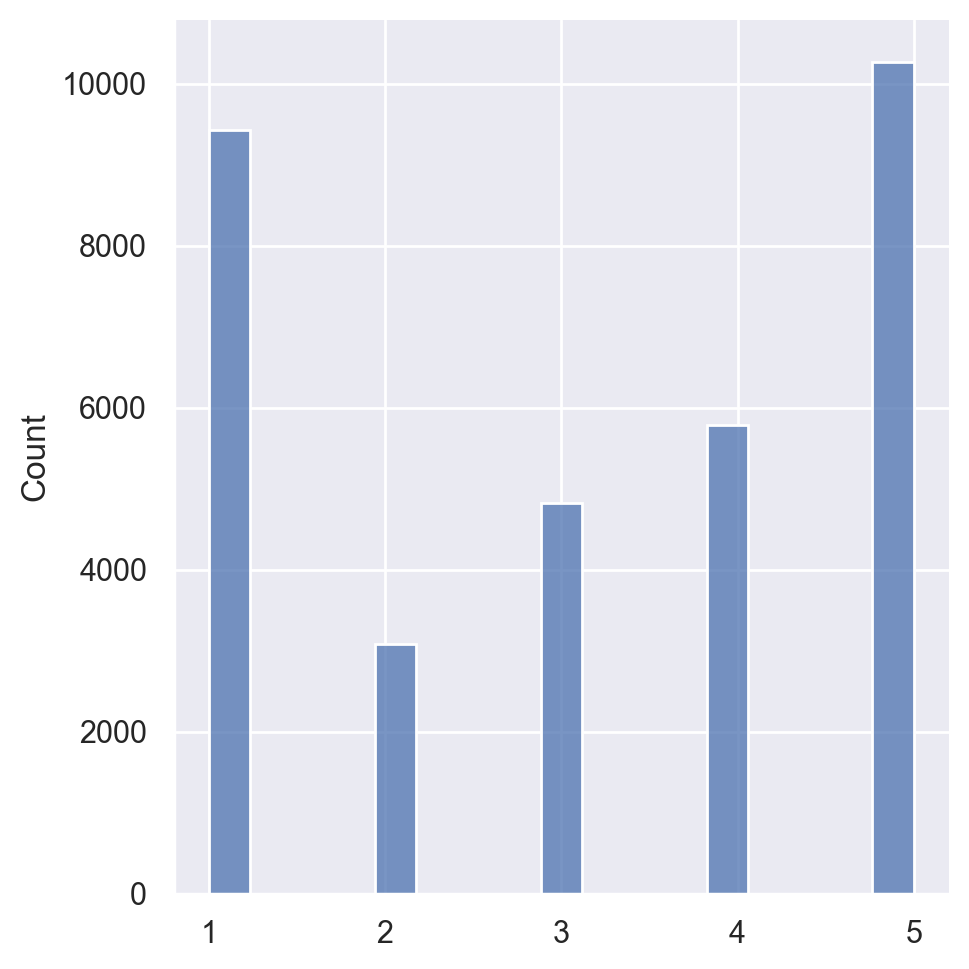

In [13]:
sns.displot(label_data)

### Aufteilung in Trainings und Validierungsdaten 

In [14]:
train_data, test_data, train_label, test_label = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(26716,)
(6680,)
(26716,)
(6680,)


### Text zu Dictonary Repräsentationen umbauen
Als Best Practice für Word Classification gibt das Buch Deep Learning with Python die Nutzung von 20000 Token an.
Als Vectorication Mehotik. N-Gramme sind Sequenzen von aufeinanderfolgenden Elementen in einer gegebenen Textsequenz. 
Ein N-Gramm mit einem Wert von N besteht aus N aufeinanderfolgenden Elementen, die in der Regel Wörter oder Zeichen sind. Zum Beispiel besteht ein 2-Gramm (auch Bigramm genannt) aus zwei aufeinanderfolgenden Wörtern in einem Text, während ein 3-Gramm (Trigramm) aus drei aufeinanderfolgenden Wörtern besteht.

Außerdem nutzen wir eine Multi-Hot-Kodierung als Ausgabe.
Bei der Multi-Hot-Kodierung wird für jedes Merkmal eine binäre Darstellung verwendet, bei der jedes Merkmal durch eine Position im Vektor repräsentiert wird. Jede Position im Vektor steht für eine mögliche Kategorie des Merkmals. Wenn ein bestimmtes Element eines Merkmals vorhanden ist, wird der entsprechende Wert in der Vektorrepräsentation auf 1 gesetzt. Andernfalls wird der Wert auf 0 gesetzt.

In [15]:
text_vectorization = TextVectorization(
 max_tokens=20000,
ngrams=2,
 output_mode="multi_hot",
 standardize=None
)

In [16]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

### Hot Encoding der Lables
Multi Hot Encoding nutzen wir auch für die Labels.

In [17]:
train_label_one_hot = tf.one_hot(train_label, 5)
train_label_one_hot.shape

TensorShape([26716, 5])

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks
Damit wir hier ein Softmax output Layer nutzen können um in 5 Klassen die Daten Klassifizieren können.
Als Besonderheit nutzen wir noch ein Drop out Layer. 
Ein Dropout-Layer ist eine spezielle Art von Schicht in einem neuronalen Netzwerk, die dazu dient, Overfitting (Überanpassung) zu reduzieren. Overfitting tritt auf, wenn ein neuronales Netzwerk sehr gut auf die Trainingsdaten passt, aber eine schlechte Leistung auf neuen, unbekannten Daten zeigt.

Der Dropout-Layer funktioniert, indem er während des Trainings zufällig eine bestimmte Anzahl von Ausgabefunktionen (Neuronen) "auslässt" oder "fallen lässt". Das bedeutet, dass diese Neuronen während eines bestimmten Trainingsdurchlaufs keine Informationen an die nachfolgende Schicht weitergeben.

In [18]:
def get_model(max_tokens=20000, hidden_dim=32):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dropout(0.5)(x)
 outputs = layers.Dense(5, activation="softmax")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="categorical_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         


                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 640,197
Trainable params: 640,197
Non-trainable params: 0
_________________________________________________________________


## Durchführung von In-sample und Out-of-sample Prognosen sowie Bestimmungen sowie Bestimmung der Prognossegüter anhand geeigneter Metriken 

In [19]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]
history = model.fit(multi_hot_train_data, train_label_one_hot, validation_split=0.2, epochs=10, callbacks= callbacks)

Epoch 1/10


668/668 [==============================] - 7s 9ms/step - loss: 0.8606 - accuracy: 0.3748 - val_loss: 0.6626 - val_accuracy: 0.4452
Epoch 2/10
668/668 [==============================] - 6s 9ms/step - loss: 1.0150 - accuracy: 0.3577 - val_loss: 0.6914 - val_accuracy: 0.4317
Epoch 3/10
668/668 [==============================] - 6s 9ms/step - loss: 0.9960 - accuracy: 0.3480 - val_loss: 0.6913 - val_accuracy: 0.4330
Epoch 4/10
668/668 [==============================] - 6s 9ms/step - loss: 0.8912 - accuracy: 0.3504 - val_loss: 0.6788 - val_accuracy: 0.4407


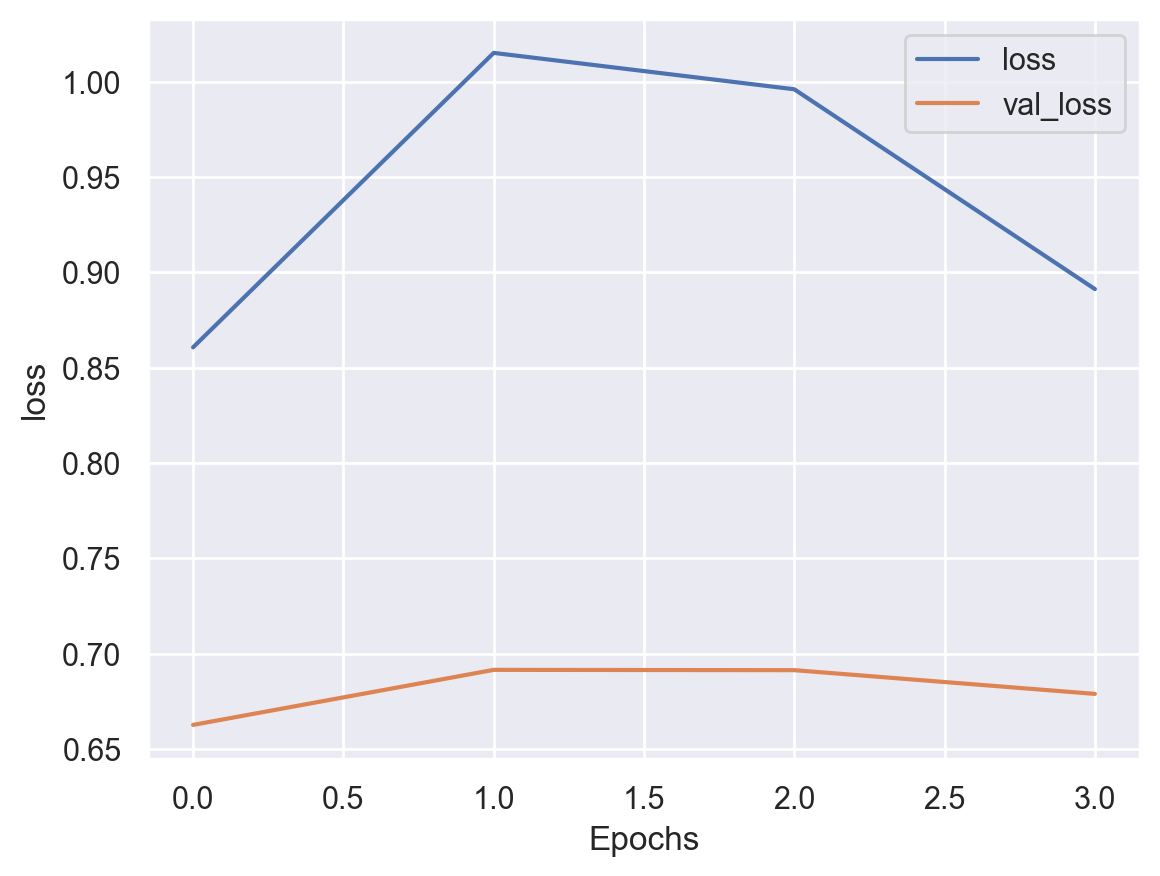

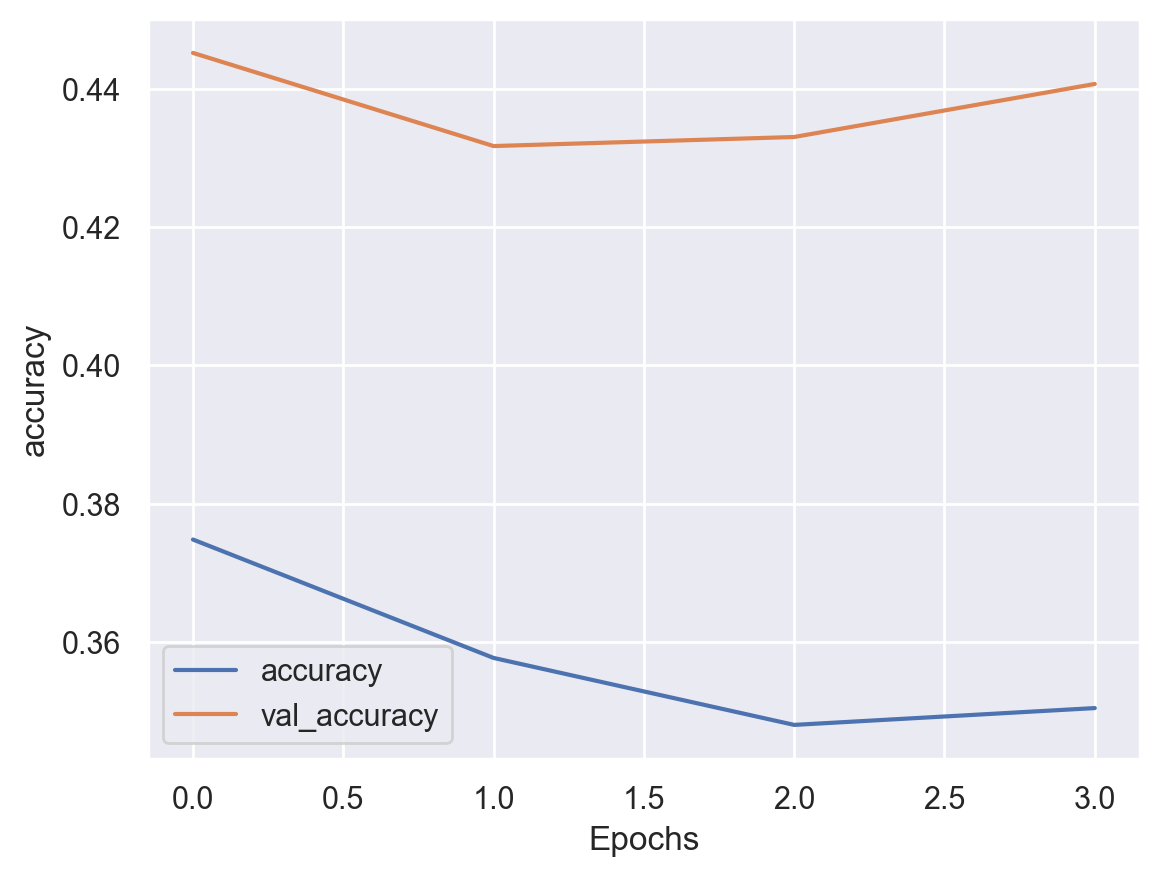

In [20]:
from utils.plot_utils import plot_history_metrics
plot_history_metrics(history, ['loss', 'accuracy'])

In [21]:
test_label_one_hot = tf.one_hot(test_label, 5)
model.evaluate(multi_hot_test_data,test_label_one_hot)

209/209 [==============================] - 1s 2ms/step - loss: 0.6628 - accuracy: 0.4397


[0.6627643704414368, 0.4396706521511078]

## Fazit

Wir kommen auf Out-of Samlple accuracy von 45%. Als Ziel haben wir uns 20 % Prozent gesetzt, weil wir 5 verschiedene Lables haben und alles drunter nur Raten wäre. Somit hat unsere Analyse das Ziel erreicht.